In [1]:
%%bash
echo "🧹 Removing broken Triton & bitsandbytes folders..."

rm -rf /usr/local/lib/python3.*/dist-packages/triton*
rm -rf /usr/local/lib/python3.*/dist-packages/bitsandbytes*
rm -rf /usr/local/lib/python3.*/dist-packages/bnb*


🧹 Removing broken Triton & bitsandbytes folders...


In [2]:
%%bash
echo "⬇️ Installing PyTorch + bitsandbytes + triton combo known to work"

pip install -q --no-cache-dir torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 \
  -f https://download.pytorch.org/whl/torch_stable.html

pip install -q --no-cache-dir triton==2.1.0.post1
pip install -q --no-cache-dir bitsandbytes==0.43.1

pip install -q --no-cache-dir \
  transformers==4.41.1 peft==0.11.1 accelerate==0.29.3 datasets einops requests


⬇️ Installing PyTorch + bitsandbytes + triton combo known to work
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 177.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 174.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 190.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 275.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 182.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 239.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/

ERROR: Could not find a version that satisfies the requirement triton==2.1.0.post1 (from versions: 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 3.0.0, 3.1.0, 3.2.0, 3.3.0, 3.3.1)
ERROR: No matching distribution found for triton==2.1.0.post1


In [1]:
import gc, torch, requests, math, random
import bitsandbytes as bnb
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader

torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [2]:
MODEL_ID = "tiiuae/falcon-rw-1b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token  # safe padding

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map={"": 0}
)
base_model.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(50304, 2048)
    (h): ModuleList(
      (0-23): 24 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): Linear4bit(in_features=2048, out_features=6144, bias=True)
          (dense): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): Linear4bit(in_features=2048, out_features=8192, bias=True)
          (act): GELUActivation()
          (dense_4h_to_h): Linear4bit(in_features=8192, out_features=2048, bias=True)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2048, out_features=50304, bias=Fa

In [3]:
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query_key_value"],
    lora_dropout=0.05
)
model = get_peft_model(base_model, lora_cfg)
model.print_trainable_parameters()


trainable params: 1,572,864 || all params: 1,313,198,080 || trainable%: 0.1198


In [4]:
url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
raw = requests.get(url).json()

samples = []
for art in raw["data"]:
    for para in art["paragraphs"]:
        ctx = para["context"]
        for qa in para["qas"]:
            if len(samples) >= 200: break
            samples.append({"question": qa["question"], "context": ctx})
        if len(samples) >= 200: break
    if len(samples) >= 200: break

MAXLEN = 128

def tok(example):
    txt = f"question: {example['question']} context: {example['context']}"
    return tokenizer(txt, return_tensors="pt", padding="max_length", truncation=True, max_length=MAXLEN)

dataset = [tok(s) for s in samples]

def collate(batch):
    ids = torch.stack([b["input_ids"].squeeze(0) for b in batch])
    msk = torch.stack([b["attention_mask"].squeeze(0) for b in batch])
    return {"input_ids": ids, "attention_mask": msk, "labels": ids.clone()}

dloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate)
iter_dl = iter(dloader)


In [5]:
STEPS        = 400
K_SCHED      = 100
EMA_DECAY    = 0.7
R_MIN, R_MAX = 4, 32
VRAM_LIMIT   = 10 * 1024  # ~10 GB

lora_layers = {n: m for n, m in model.named_modules() if hasattr(m, "lora_A")}

def vram_mb():
    return torch.cuda.memory_allocated() / 1e6

def r(layer):
    return next(layer.lora_A.parameters()).size(0)

def shrink(layer):
    old = r(layer)
    new = max(R_MIN, old // 2)
    if new != old:
        print(f"  ↧ {old} → {new}")
        layer.update_layer(
            adapter_name="default",
            r=new,
            lora_alpha=layer.lora_alpha["default"],
            lora_dropout=getattr(layer.lora_dropout, 'p', 0.0),
            init_lora_weights=True,
            use_rslora=False
        )

def expand(layer):
    old = r(layer)
    new = min(R_MAX, old * 2)
    if new != old:
        print(f"  ↥ {old} → {new}")
        layer.update_layer(
            adapter_name="default",
            r=new,
            lora_alpha=layer.lora_alpha["default"],
            lora_dropout=getattr(layer.lora_dropout, 'p', 0.0),
            init_lora_weights=True,
            use_rslora=False
        )




In [6]:
optim = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-4)
curv = {}
losses = []


In [7]:
gc.collect()
torch.cuda.empty_cache()
model.to(DEVICE)

iter_dl = iter(dloader)

for step in range(STEPS):
    try:
        batch = next(iter_dl)
    except StopIteration:
        iter_dl = iter(dloader)
        batch = next(iter_dl)

    batch = {k: v.to(DEVICE) for k, v in batch.items()}

    optim.zero_grad(set_to_none=True)
    loss = model(**batch).loss
    loss.backward()
    optim.step()

    losses.append(loss.item())
    print(f"Step {step} | Loss {loss.item():.4f} | VRAM {vram_mb():.0f} MB")

    # Curvature (EMA of grad²)
    for name, layer in lora_layers.items():
        if layer.weight.grad is not None:
            g2 = layer.weight.grad.float().pow(2).mean().item()
            curv[name] = EMA_DECAY * curv.get(name, 0.0) + (1 - EMA_DECAY) * g2

    # DRaFT‑Q Rank Scheduler
    if step > 0 and step % K_SCHED == 0:
        for n, l in lora_layers.items():
            if curv.get(n, 0) > 1e-4 and r(l) < R_MAX:
                expand(l)
            elif curv.get(n, 0) < 1e-6 and r(l) > R_MIN:
                shrink(l)

        new_params = [p for p in model.parameters()
                      if p.requires_grad and all(p is not q for g in optim.param_groups for q in g["params"])]
        if new_params:
            optim.add_param_group({"params": new_params})

        while vram_mb() > VRAM_LIMIT:
            victim = max(lora_layers, key=lambda n: r(lora_layers[n]))
            shrink(lora_layers[victim])


Step 0 | Loss 2.8086 | VRAM 1104 MB
Step 1 | Loss 3.0312 | VRAM 1281 MB
Step 2 | Loss 2.9336 | VRAM 1104 MB
Step 3 | Loss 2.7500 | VRAM 1282 MB
Step 4 | Loss 2.9160 | VRAM 1285 MB
Step 5 | Loss 2.6230 | VRAM 1107 MB
Step 6 | Loss 2.2871 | VRAM 1285 MB
Step 7 | Loss 3.0703 | VRAM 1282 MB
Step 8 | Loss 3.1211 | VRAM 1106 MB
Step 9 | Loss 3.0488 | VRAM 1283 MB
Step 10 | Loss 2.8672 | VRAM 1105 MB
Step 11 | Loss 2.1582 | VRAM 1282 MB
Step 12 | Loss 2.6523 | VRAM 1283 MB
Step 13 | Loss 2.6797 | VRAM 1106 MB
Step 14 | Loss 2.1699 | VRAM 1281 MB
Step 15 | Loss 2.3789 | VRAM 1280 MB
Step 16 | Loss 2.8887 | VRAM 1106 MB
Step 17 | Loss 2.4727 | VRAM 1285 MB
Step 18 | Loss 2.5371 | VRAM 1106 MB
Step 19 | Loss 2.2188 | VRAM 1283 MB
Step 20 | Loss 2.6152 | VRAM 1283 MB
Step 21 | Loss 2.5137 | VRAM 1107 MB
Step 22 | Loss 2.4121 | VRAM 1283 MB
Step 23 | Loss 2.1367 | VRAM 1282 MB
Step 24 | Loss 2.2285 | VRAM 1104 MB
Step 25 | Loss 2.1992 | VRAM 1280 MB
Step 26 | Loss 2.7598 | VRAM 1106 MB
Step 27 | L

In [8]:
model.eval()
prompt = "Question: Who wrote the play Hamlet? Context: William Shakespeare was an English playwright."
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=20)

print(tokenizer.decode(out[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: Who wrote the play Hamlet? Context: William Shakespeare was an English playwright. He is considered the greatest of the medieval English dramatists and is considered the most popular of the


In [9]:
prompt = "Question: Who wrote the play Hamlet? Context: William Shakespeare was an English playwright."
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20, do_sample=True, temperature=0.7)

print(tokenizer.decode(output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question: Who wrote the play Hamlet? Context: William Shakespeare was an English playwright. He wrote over thirty-five plays, including A Midsummer Night's Dream, The Two Gentle


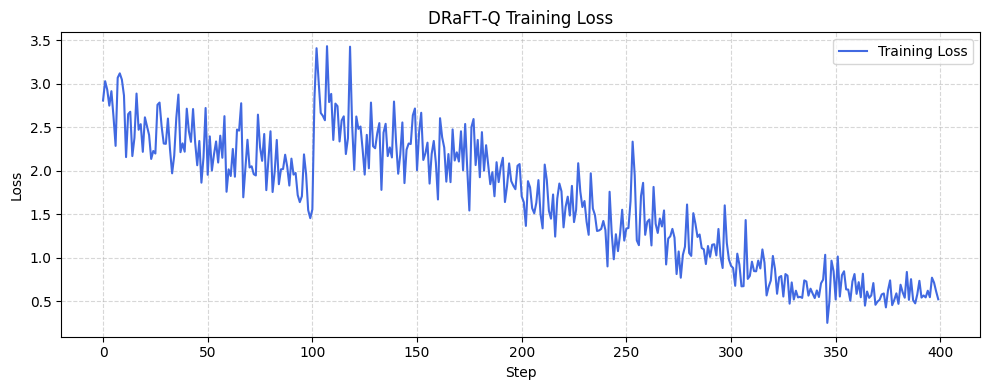

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss", color="royalblue")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("DRaFT‑Q Training Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
